## Step by Step plots of LOESS (LOcally Estimated Scatterplot Smoothing)

NOTES:
1. Use xarray / dask to parallelize?
1. ~~Determine if we can save time by caching grid / stencil for regression~~ -- DONE (looks good on hi-res grids)
1. ~~Expand to 2D and then data on globe (convert $(\lambda, \theta)$ on unit circle to $(x, y, z=\sqrt{1-x^2-y^2})$ and then compute norm)~~ -- DONE (slight improvement in RMSE and max errors)
1. Read `TLAT` and `TLON` from a POP history file rather than generating random points for the global case
1. Handle missing values somehow (maybe have option to pass a mask and ignore masked data?)
1. Account for land when computing distance matrix (we may want an off-line tool to generate the matrix)

#### Initial Setup

Import modules, define plot size parameter, define `RMSE()` for error checking, and set `(x, y)` for plotting.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Initial imports

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy
import cartopy.crs as ccrs
from plotbin.plot_velfield import plot_velfield
from my_loess.loess import linear_loess
from my_loess.loess import evaluate_poly

# These are Cappellari's loess_{1,2}d modules, except
# I apply robustness weights twice rather than
# have logic to determine how many times to apply
try:
    from my_loess.loess_1d import loess_1d
except:
    from loess.loess_1d import loess_1d
try:
    from my_loess.loess_2d import loess_2d
except:
    from loess.loess_2d import loess_2d


In [3]:
# Place figures within document
# This is in its own cell otherwise rcParams set is ignored
# (Possibly related to https://github.com/jupyter/notebook/issues/3385)
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0) # Large figures

# Lastly, define RMSE function for comparing results
def RMSE(est_val, true_val):
    """ sqrt(1/n * sum of square differences)
    """
    assert est_val.size == true_val.size, "Arrays must be same size"
    N = est_val.size
    print("RMSE: {:.4f}".format(np.sqrt(np.sum((est_val - true_val)**2)/N)))

Comparing to software package from Cappellari et al. (2013) => test with same example as found in loess_1d

In [4]:
# Set number of plot points and seed random number generator
tot_points = 200
np.random.seed(123)

# use same x values as loess_1d example
x_1d = np.sort(np.random.uniform(-1, 1, tot_points))

# use same y values as loess_1d example
# (1) start with y = sin(3x)
f1d_true = np.sin(3*x_1d)
# (2) add some small random noise (sigma = 0.4)
f1d_eval = np.random.normal(f1d_true, 0.4)
# (3) to 10% of the points, add larger random noise (sigma = 2)
bad_inds = np.random.randint(0, tot_points, int(tot_points*0.1))
f1d_eval[bad_inds] += np.random.normal(0, 2, bad_inds.size)
RMSE(f1d_eval, f1d_true)

# Choose n (d assumed to be 1 for now)
n = 60 # 30% of tot_points
#d = 1  # We will use linear regression

# initialize class
%time my_1d = linear_loess(x_1d, 60)

RMSE: 0.6385
CPU times: user 254 ms, sys: 2.48 ms, total: 257 ms
Wall time: 255 ms


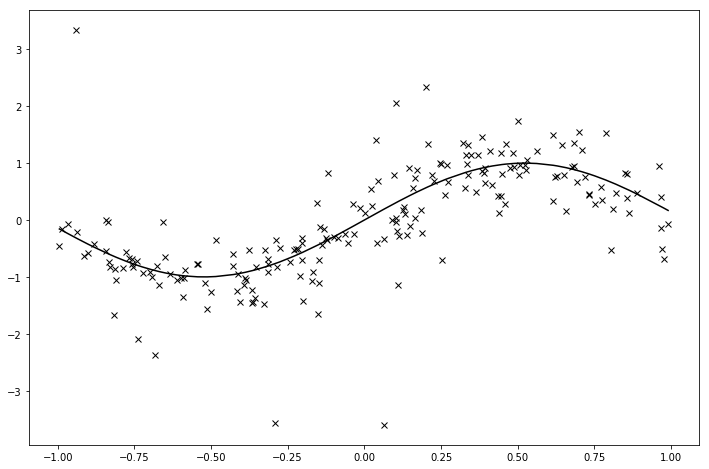

In [5]:
plt.plot(np.squeeze(np.asarray(my_1d.grid['coord_matrix'][0,:])), f1d_true, 'k')
plt.plot(np.squeeze(np.asarray(my_1d.grid['coord_matrix'][0,:])), np.squeeze(np.asarray(f1d_eval)), 'kx')

#### 1. Polynomial fit

Using notation from Cleveland (1979), the goal is to determine $\{\hat{y}_i\}$, estimates of $\{y_i\}$ from points $(x, y) \in \{(x_i, y_i)\}$

For this step, we fit a polynomial of degree $d$ to the $n$ points $(x_j, y_j)$ where $x_j$ represents the $n$ closest points to $x_i$.
Use weighted regression with weight function $W(x) = (1 - (|x_i - x_j|/h_i)^3)^3$, where $h_i = \max(|x_i - x_j|)$ among the $n$ points

CPU times: user 3.48 ms, sys: 238 µs, total: 3.72 ms
Wall time: 3.69 ms


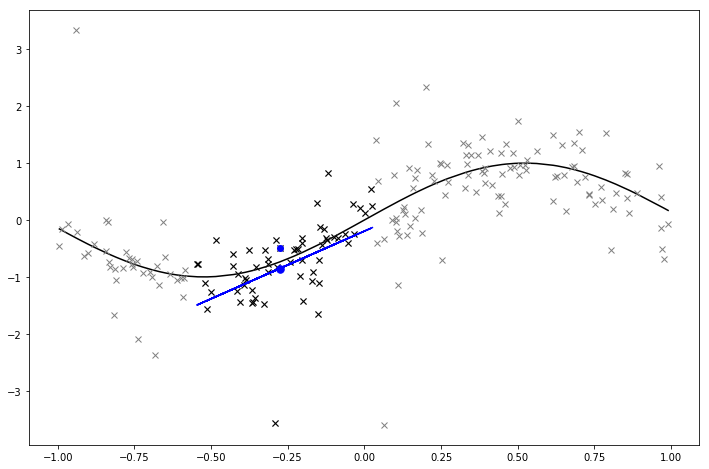

In [6]:

# Pick a point ~1/3 of the way into the domain
i = tot_points//3

%time poly_1d_coeffs, xj_1d, f1dj = my_1d.poly_fit_at_i(i, f1d_eval)

f1d_hati = evaluate_poly(poly_1d_coeffs, my_1d.grid['coord_matrix'].data[:,i])
f1d_hat = evaluate_poly(poly_1d_coeffs, xj_1d)

# True distribution is solid black
plt.plot(x_1d, f1d_true, 'k')
# Sampled data is gray x
plt.plot(x_1d, f1d_eval, 'x', color="grey")
# Sampled data used for local regression is black x
plt.plot(np.squeeze(np.array(xj_1d)), f1dj, 'kx')
# Node i in blue dot
plt.plot(x_1d[i], f1d_eval[i], 'bo')
# Local polynomial fit in solid blue
plt.plot(np.squeeze(np.array(xj_1d)), f1d_hat, 'b')
# Estimated value at x[i] is big blue *
plt.plot(x_1d[i], f1d_hati, 'bo', markersize=7.5)

#### 2. Apply Robustness Weights (locally)

CPU times: user 1.5 ms, sys: 436 µs, total: 1.93 ms
Wall time: 1.47 ms


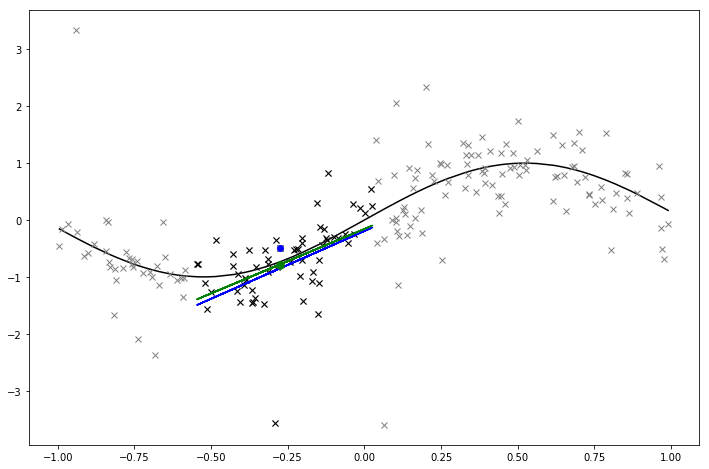

In [7]:
# Choose n and d
n = 60 # 30% of tot_points
d = 1  # We will use linear regression

# Pick a point ~1/3 of the way into the domain
i = tot_points//3

%time poly_1d_coeffs, xj_1d, f1dj = my_1d.poly_fit_at_i(i, f1d_eval, t=2)

#f1d_hati = evaluate_poly(poly_1d_coeffs, x_1d[i])
f1d_hati = evaluate_poly(poly_1d_coeffs, my_1d.grid['coord_matrix'].data[:,i])
f1d_hat2 = evaluate_poly(poly_1d_coeffs, xj_1d)

# True distribution is solid black
plt.plot(x_1d, f1d_true, 'k')
# Sampled data is gray x
plt.plot(x_1d, f1d_eval, 'x', color="grey")
# Sampled data used for local regression is black x
plt.plot(np.squeeze(np.array(xj_1d)), f1dj, 'kx')
# Node i in blue dot
plt.plot(x_1d[i], f1d_eval[i], 'bo')
# Local polynomial fit in solid blue
plt.plot(np.squeeze(np.array(xj_1d)), f1d_hat, 'b')
# Robustness adjusted polynomial fit in solid green
plt.plot(np.squeeze(np.array(xj_1d)), f1d_hat2, 'g')
# Newly estimated value at x[i] is big green *
plt.plot(x_1d[i], f1d_hati, 'go', markersize=7.5)

#### 3. Repeat this process for all nodes

In [8]:
%time f1d_hat = my_1d.poly_fit(f1d_eval, t=2)
RMSE(f1d_hat, f1d_true)

CPU times: user 179 ms, sys: 1.62 ms, total: 181 ms
Wall time: 179 ms
RMSE: 0.0768


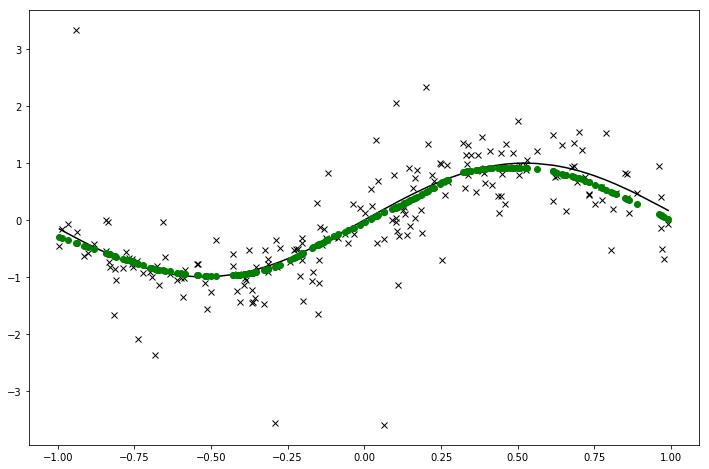

In [9]:
# True distribution is solid black
plt.plot(x_1d, f1d_true, 'k')
# Sampled data in black x
plt.plot(x_1d, f1d_eval, 'kx')
# Robust estimated values at each x[i] is green dot
plt.plot(x_1d, f1d_hat, 'go')

#### Compare to loess_1d package

CPU times: user 112 ms, sys: 1.78 ms, total: 114 ms
Wall time: 112 ms
RMSE: 0.0765
Largest difference between loess package and code above: 0.008615650250092283


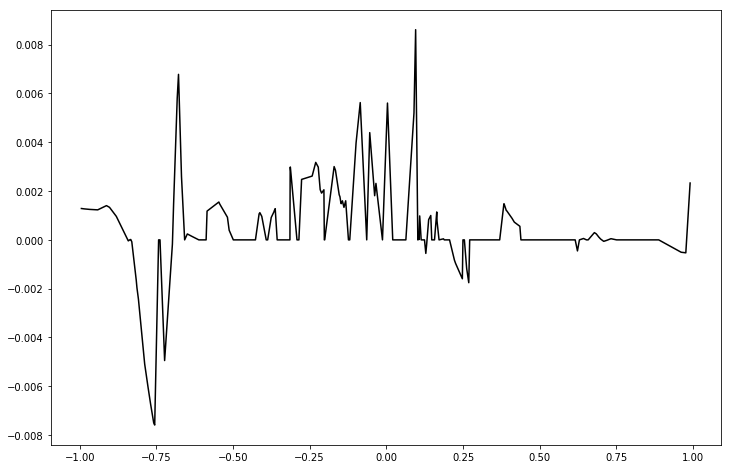

In [10]:
%time x1d_out, f1d_hat2, weigts = loess_1d(x_1d, f1d_eval, frac=0.3)
RMSE(f1d_hat2, f1d_true)

diff = f1d_hat2 - f1d_hat
plt.plot(x_1d, diff, 'k')
print("Largest difference between loess package and code above: {}".format(np.max(np.abs(diff))))

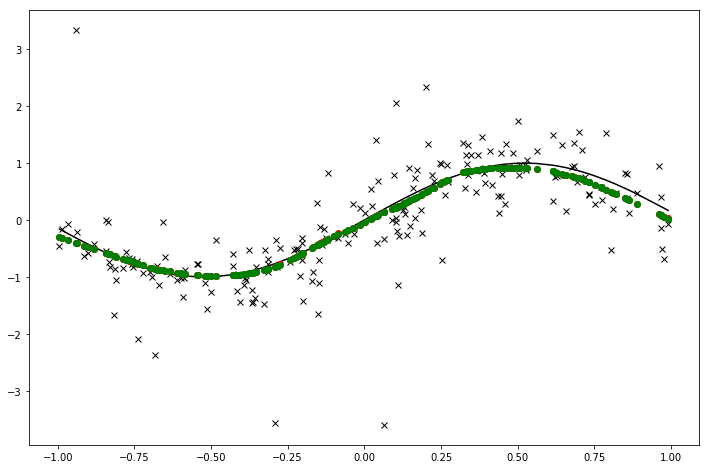

In [11]:
# True distribution is solid black
plt.plot(x_1d, f1d_true, 'k')
# Sampled data in black x
plt.plot(x_1d, f1d_eval, 'kx')
# loess package estimated value at each x[i] is red dot
plt.plot(x_1d, f1d_hat2, 'ro')
# My estimated value at each x[i] is green dot
plt.plot(x_1d, f1d_hat, 'go')

### 2D example

In [12]:
np.random.seed(123)
tot_points = 200
x_2d = np.random.uniform(-1,1,tot_points)
y_2d = np.random.uniform(-1,1,tot_points)
f2d_true = x_2d**2 - y_2d**2
sigz = 0.2
f2d_eval = np.random.normal(f2d_true, sigz)
RMSE(f2d_eval, f2d_true)

RMSE: 0.1962


Initializing grid data...
CPU times: user 231 ms, sys: 3.05 ms, total: 234 ms
Wall time: 232 ms
Computing LOESS smoothing...
CPU times: user 824 ms, sys: 15.7 ms, total: 839 ms
Wall time: 212 ms
RMSE: 0.1088


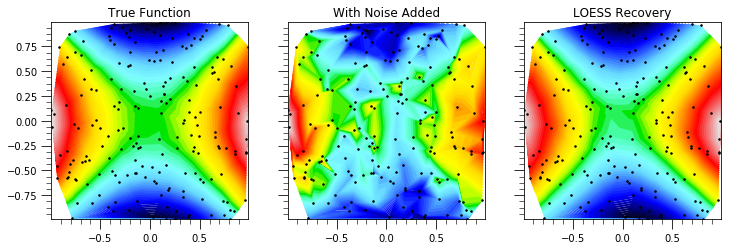

In [13]:
# initialize class
n = 100
#d = 1
print("Initializing grid data...")
%time my_2d = linear_loess(np.array([x_2d, y_2d]), n)
print("Computing LOESS smoothing...")
%time f2d_hat = my_2d.poly_fit(f2d_eval, t=2)
RMSE(f2d_hat, f2d_true)

plt.clf()
plt.subplot(131)
plot_velfield(x_2d, y_2d, f2d_true)
plt.title("True Function")

plt.subplot(132)
plot_velfield(x_2d, y_2d, f2d_eval)
plt.title("With Noise Added")
plt.tick_params(labelleft=False)

plt.subplot(133)
plot_velfield(x_2d, y_2d, f2d_hat)
plt.title("LOESS Recovery")
plt.tick_params(labelleft=False)

CPU times: user 470 ms, sys: 15.9 ms, total: 486 ms
Wall time: 123 ms
RMSE: 0.1086


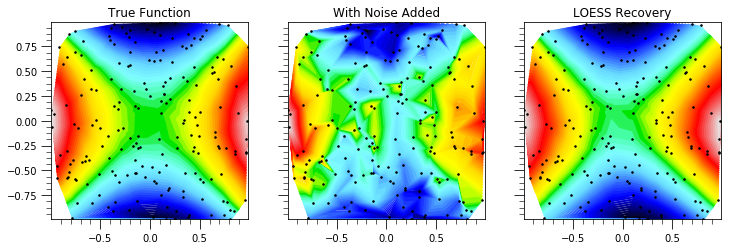

In [14]:
%time f2d_hat2, wout = loess_2d(x_2d, y_2d, f2d_eval)
RMSE(f2d_hat2, f2d_true)

plt.clf()
plt.subplot(131)
plot_velfield(x_2d, y_2d, f2d_true)
plt.title("True Function")

plt.subplot(132)
plot_velfield(x_2d, y_2d, f2d_eval)
plt.title("With Noise Added")
plt.tick_params(labelleft=False)

plt.subplot(133)
plot_velfield(x_2d, y_2d, f2d_hat2)
plt.title("LOESS Recovery")
plt.tick_params(labelleft=False)

RMSE: 0.0006
Min diff: -0.0026681384859392754
Max diff: 0.003953171139693623


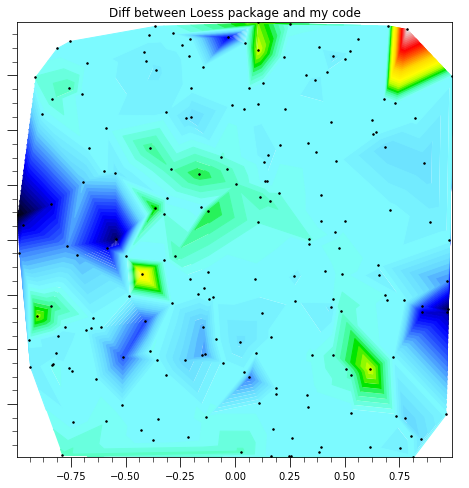

In [15]:
RMSE(f2d_hat, f2d_hat2)
print("Min diff: {}\nMax diff: {}".format(np.min(f2d_hat - f2d_hat2), np.max(f2d_hat - f2d_hat2)))
plot_velfield(x_2d, y_2d, f2d_hat - f2d_hat2)
plt.title("Diff between Loess package and my code")
plt.tick_params(labelleft=False)

### Global example

In [16]:
np.random.seed(123)
nlat = 90
nlon = 180
tot_points = nlat*nlon

# Define grid
lon_1d = np.random.uniform(0, 2.0*np.pi, nlon)
lon_1d.sort()
lat_1d = np.random.uniform(-np.pi/2.0, np.pi/2.0, nlat)
lat_1d.sort()

lon = np.empty((nlon, nlat))
lat = np.empty((nlon, nlat))
for j in range(nlat):
    lon[:,j] = lon_1d
for i in range(nlon):
    lat[i, :] = lat_1d

# Define cosine bell curve
def bell_curve(lon_in, lat_in):
    clon = 1.5*np.pi
    clat = np.pi/6.0
    R = np.pi/6.0
    r_sqr = np.where((lon_in-clon)**2 + (lat_in-clat)**2 < R**2, (lon_in-clon)**2 + (lat_in-clat)**2, R**2)
    return (1.0 - np.sqrt(r_sqr)/R)

fglob_true = bell_curve(lon, lat)
sigz = 0.2
fglob_eval = np.random.normal(fglob_true, sigz)
RMSE(fglob_eval, fglob_true)

RMSE: 0.1997


In [17]:
# initialize class
n = 384
grid_file = '{}x{}_n{}.nc'.format(nlat, nlon, n)

if os.path.isfile(grid_file):
    print("Reading grid information from {}".format(grid_file))
    my_glob = linear_loess(grid_file=grid_file)
else:
    print("Computing grid information (including distance matrix)")
    %time my_glob = linear_loess(np.matrix([lon.reshape(tot_points), lat.reshape(tot_points)]), n, convert_lat_lon=True)
    #my_glob.grid.to_netcdf(grid_file)

print('Computing LOESS smoothed values')
%time fglob_hat = my_glob.poly_fit(fglob_eval.reshape(tot_points), t=0).reshape(nlon, nlat)
RMSE(fglob_hat, fglob_true)
fglob_err = fglob_hat - fglob_true
print("Min: {}\nMax: {}".format(np.min(fglob_err), np.max(fglob_err)))

Reading grid information from 90x180_n384.nc
Computing LOESS smoothed values
CPU times: user 35.1 s, sys: 926 ms, total: 36 s
Wall time: 9.1 s
RMSE: 0.0280
Min: -0.1476800113752299
Max: 0.10824934286350907


Starting plots...
CPU times: user 21.4 s, sys: 68.1 ms, total: 21.5 s
Wall time: 21.1 s


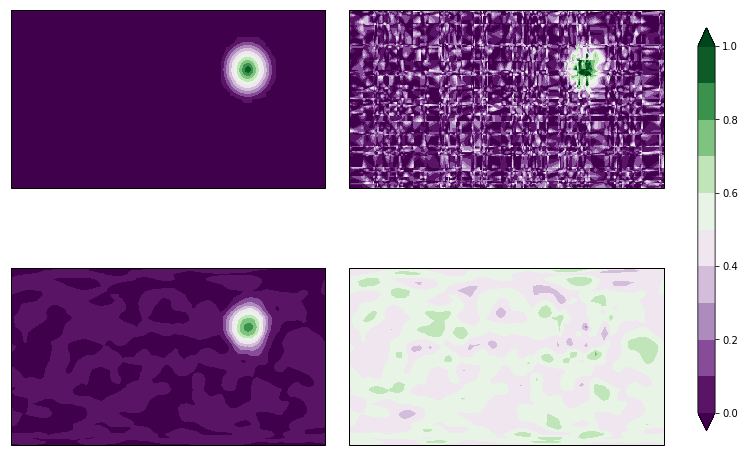

In [18]:
%%time

print("Starting plots...")
nlev = 10
clevels = [1.0*lev/nlev for lev in range(nlev+1)]
err_levels = [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]
fig= plt.figure(figsize=(12,8));
ax00 = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf00 = ax00.contourf(lon, lat, fglob_true, levels=clevels, transform=ccrs.PlateCarree(), cmap='PRGn', extend='both')
ax01 = fig.add_subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=305.0))
cf01 = ax01.contourf(lon, lat, fglob_eval, levels=clevels, transform=ccrs.PlateCarree(), cmap='PRGn', extend='both')
ax10 = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=305.0))
cf10 = ax10.contourf(lon, lat, fglob_hat, levels=clevels, transform=ccrs.PlateCarree(), cmap='PRGn', extend='both')
ax11 = fig.add_subplot(2, 2, 4, projection=ccrs.Robinson(central_longitude=305.0))
cf11 = ax11.contourf(lon, lat, fglob_err, levels=err_levels, transform=ccrs.PlateCarree(), cmap='PRGn', extend='both')
                     
fig.subplots_adjust(hspace=0.45, wspace=0.02, right=0.9)
cax = plt.axes((0.93, 0.15, 0.02, 0.7))
fig.colorbar(cf00, cax=cax)